In [1]:
%cd ..

%load_ext line_profiler
from IPython.core.debugger import set_trace

/home/proste/mff/evgena


In [2]:
from genetals.core import *
from genetals.callbacks import GAStatus, MultiObjectiveReport
from genetals.operators import TwoPointXover, BiasedMutation, ShuffleOperator, NSGAOperator
from genetals.initializers import RandomStdInit
from evgena.datasets import load_emnist, load_mnist, load_nprecord
from evgena.models import Model
from evgena.utils.large_files import maybe_download

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/home/proste/mff/evgena/env_evgena/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class SSIM:
    def __init__(self, size=11, sigma=1.5, K1=0.01, K2=0.03, seed=42):
        graph = tf.Graph()
        graph.seed = seed
        self.session = tf.Session(graph=graph)
        
        with self.session.graph.as_default():
            # input placeholders
            self.images_x = tf.placeholder(tf.float32, [None, None, None, 1], name='images_x')  # TODO shapes??
            self.images_y = tf.placeholder(tf.float32, [None, None, None, 1], name='images_y')
            
            # weighting gaussian window
            window_half = size // 2
            x_data, y_data = np.mgrid[-window_half:window_half+1,-window_half:window_half+1]

            g = np.exp(-((x_data**2 + y_data**2)/(2.0*sigma**2)))
            normed_g = g / np.sum(g)
            normed_g = normed_g.reshape(normed_g.shape + (1, 1))
            
            window = tf.constant(normed_g, dtype=tf.float32)
            
            C1 = tf.constant(K1**2, dtype=tf.float32)
            C2 = tf.constant(K2**2, dtype=tf.float32)
            C3 = tf.constant((K2**2) / 2, dtype=tf.float32)
            
            # ssim computation
            mu_x = tf.nn.conv2d(self.images_x, window, strides=[1, 1, 1, 1], padding='VALID')
            mu_x_sq = mu_x * mu_x
            sigma_x_sq = tf.nn.conv2d(self.images_x*self.images_x, window, strides=[1, 1, 1, 1], padding='VALID') - mu_x_sq
            sigma_x = tf.sqrt(sigma_x_sq)
            
            mu_y = tf.nn.conv2d(self.images_y, window, strides=[1, 1, 1, 1], padding='VALID')
            mu_y_sq = mu_y * mu_y
            sigma_y_sq = tf.nn.conv2d(self.images_y*self.images_y, window, strides=[1, 1, 1, 1], padding='VALID') - mu_y_sq
            sigma_y = tf.sqrt(sigma_y_sq)
            
            mu_xy = mu_x * mu_y
            sigma_xy = tf.nn.conv2d(self.images_x*self.images_y, window, strides=[1, 1, 1, 1], padding='VALID') - mu_xy
            
            self.ssim_luminance = (2 * mu_xy + C1) / (mu_x_sq + mu_y_sq + C1)
            self.ssim_contrast = (2 * sigma_x * sigma_y + C2) / (sigma_x_sq + sigma_y_sq + C2)
            self.ssim_structure = (sigma_xy + C3) / (sigma_x * sigma_y + C3)
            self.ssim_map = self.ssim_luminance * self.ssim_contrast * self.ssim_structure
            self.ssim_metrics = tf.reduce_mean(self.ssim_map, axis=[1, 2, 3])

    def __call__(self, images_x, images_y):
        return self.session.run(
            self.ssim_metrics,
            feed_dict={self.images_x: images_x, self.images_y: images_y}
        )

In [4]:
class MultiSigmaRandomStdInit(InitializerBase):
    def __init__(self, individual_shape, sigmas = (1,), mu: np.ndarray = 0):
        super(MultiSigmaRandomStdInit, self).__init__()

        self._individual_shape = individual_shape
        self._sigmas = sigmas
        self._mu = mu

    def __call__(self, population_size: int, *args, **kwargs) -> np.ndarray:
        result = np.random.random((population_size,) + tuple(self._individual_shape))

        split_size = (population_size + (len(self._sigmas) - 1)) // len(self._sigmas)
        for i, split_begin in enumerate(range(0, population_size, split_size)):
            result[split_begin:split_begin+split_size] *= self._sigmas[i]
            
        return self._mu + result

In [5]:
class PrePopulationInit(InitializerBase):
    def __init__(self, prepopulation):
        super(PrePopulationInit, self).__init__()

        self._prepopulation = prepopulation

    def __call__(self, population_size: int, *args, **kwargs) -> np.ndarray:
        assert population_size == len(self._prepopulation), 'Wrong pop size'  # TODO maybe tile or so
        
        return self._prepopulation

In [16]:
class Images2LabelObjectiveFnc(ObjectiveFncBase):
    def __init__(self, model: Model, target_label: int, source_images: np.ndarray, sample_size: int = 16):
        super(Images2LabelObjectiveFnc, self).__init__()
        
        self._ssim = SSIM()
        self._model = model
        self._target_label = target_label
        self._source_images = source_images
        self._sample_size = sample_size
        self._source_i = 0
      
    def __call__(self, individuals: np.ndarray) -> np.ndarray:
        # get indices of images
        # same batch for each individual
        u_bound = self._source_i + self._sample_size
        if u_bound <= len(self._source_images):
            images = self._source_images[self._source_i:u_bound]
            self._source_i = u_bound
        else:
            images = np.concatenate((self._source_images[self._source_i:], self._source_images[:u_bound - len(self._source_images)]))
            self._source_i = u_bound - len(self._source_images)  # TODO reshuffle?
        
        augmented_images = images + np.expand_dims(individuals, 1)
        augmented_images_batch_shaped = augmented_images.reshape(-1, *augmented_images.shape[2:], 1)
        
        # augment random batch with various individuals
        # TODO
        
        # for each individual sample its predictions, copmute ssim mean ssim
        norms = self._ssim(augmented_images_batch_shaped, np.expand_dims(images, 0).repeat(len(individuals), axis=0).reshape(-1, *augmented_images.shape[2:], 1))
        norms = norms.reshape(augmented_images.shape[:2])
        logits = model(augmented_images.reshape((-1,) + augmented_images.shape[2:] + (1,)))[:, self._target_label]
        logits = logits.reshape(augmented_images.shape[:2])
                       
        avg_norms = np.average(norms, axis=-1)
        avg_logits = np.average(logits, axis=-1)
        
        # create array by merging columns
        return np.stack((avg_logits, avg_norms), axis=-1)

In [7]:
tf.contrib.summary

class TfModel(Model):
    def __init__(self, path, inputs_collection, outputs_collection, batch_size: int = 32):
        super(TfModel, self).__init__()

        self._session = tf.Session(graph=tf.Graph())
        
        with self._session.graph.as_default():
            saver = tf.train.import_meta_graph(path + '.meta')
            saver.restore(self._session, path)

        self._training_phase = self._session.graph.get_collection('end_points/training_phase')[0]
        self._input = self._session.graph.get_collection(inputs_collection)[0]
        self._output = self._session.graph.get_collection(outputs_collection)[0]
        self._batch_size = batch_size

    def __call__(self, examples: np.ndarray) -> np.ndarray:
        result = np.empty([len(examples)] + self._output.shape.as_list()[1:], dtype=np.float32)
        
        for batch_begin in range(0, len(examples), self._batch_size):
            batch_end = batch_begin + self._batch_size
            result[batch_begin:batch_end] = self._session.run(self._output, feed_dict={self._training_phase: False, self._input: examples[batch_begin:batch_end]})

        return result

In [8]:
model = TfModel('models/fashion_mnist_cnn/model', 'end_points/images', 'end_points/scores', batch_size=8192)

INFO:tensorflow:Restoring parameters from models/fashion_mnist_cnn/model


In [9]:
train, test, synset, metadata = load_nprecord('fashion_mnist.npz')

In [ ]:
# model = KerasModel(maybe_download('models/best_residual_dropout_nn_emnist_2.h5'), 512)
# train, test, index = load_emnist()
# train.X = train.X * 255  # hotfix for scaled dataset  (till model changes)

In [10]:
source_class = 0
target_class = 5
images = train.X[train.y == source_class]

In [11]:
graph = OperatorGraph()

select_op = ShuffleOperator(graph.init_op)
xover_op = TwoPointXover(select_op, 0.6)
mutation_op = BiasedMutation(xover_op, sigma=0.1, l_bound=-1.0, u_bound=1.0)
moea_op = NSGAOperator(graph.init_op, mutation_op)

<IPython.core.display.Javascript object>


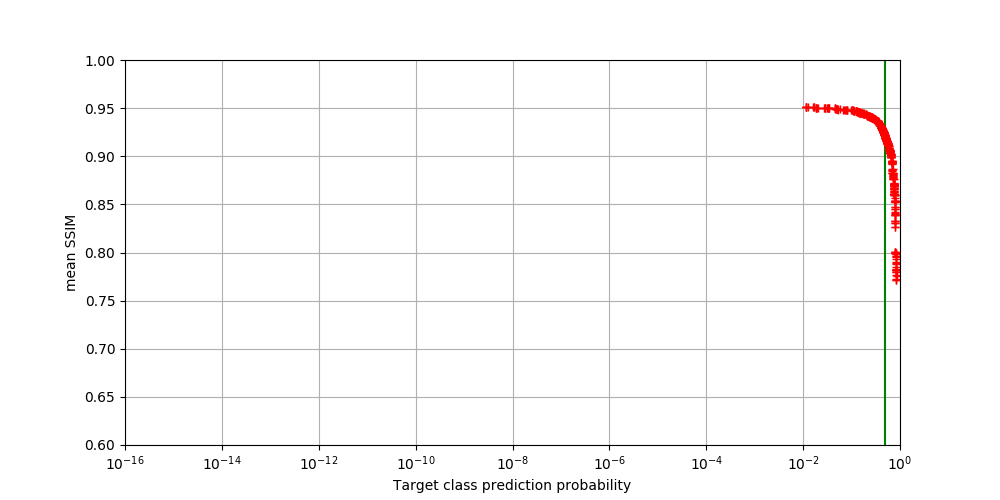

In [12]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10,5))
# fig.tight_layout()

ax.set_xlim(0.0000000000000001, 1)
ax.set_xlabel('Target class prediction probability')
ax.set_ylim(0.6, 1)
ax.set_ylabel('mean SSIM')
ax.set_xscale('log')
ax.grid(axis='both')
ax.vlines(0.5, 0, 1, colors='g')

callbacks = [GAStatus(fig), MultiObjectiveReport(ax)]

- better initialization - continuous sigma
- exponential time to live for samples
- ga.run continue easily
- proper mechanism and standardized format for ga run result storing
- callback for intermediate individual checking
- persisting ga and run

In [20]:
objFnc = Images2LabelObjectiveFnc(model, target_class, images[:64], sample_size=64)

In [21]:
ga = GeneticAlgorithm(
#     initializer=PrePopulationInit(first_run[0].individuals),
    initializer=MultiSigmaRandomStdInit((28, 28), [0.1, 0.2, 0.4]), # TODO population splits with different sigma
    operator_graph=graph,
    objective_fnc=objFnc, # TODO next sample overlaps with last sample, exponential time to live / or subset of dataset
    callbacks=callbacks
)

In [22]:
%time final_pop, fitnesses, objectives = ga.run(population_size=512, generation_cap=256)

CPU times: user 2min 30s, sys: 1min 12s, total: 3min 42s
Wall time: 3min 31s


In [23]:
first_run = final_pop, fitnesses, objectives

ssim to tensorflow

In [24]:
objectives[-1, :, 0].argmax()

55

In [25]:
objectives[-1, :, 1][objectives[-1, :, 0] > 0.5].argmax()

89

In [ ]:
np.where(objectives[-1, :, 0] > 0.5)[0][37]

In [ ]:
objectives.shape

<IPython.core.display.Javascript object>


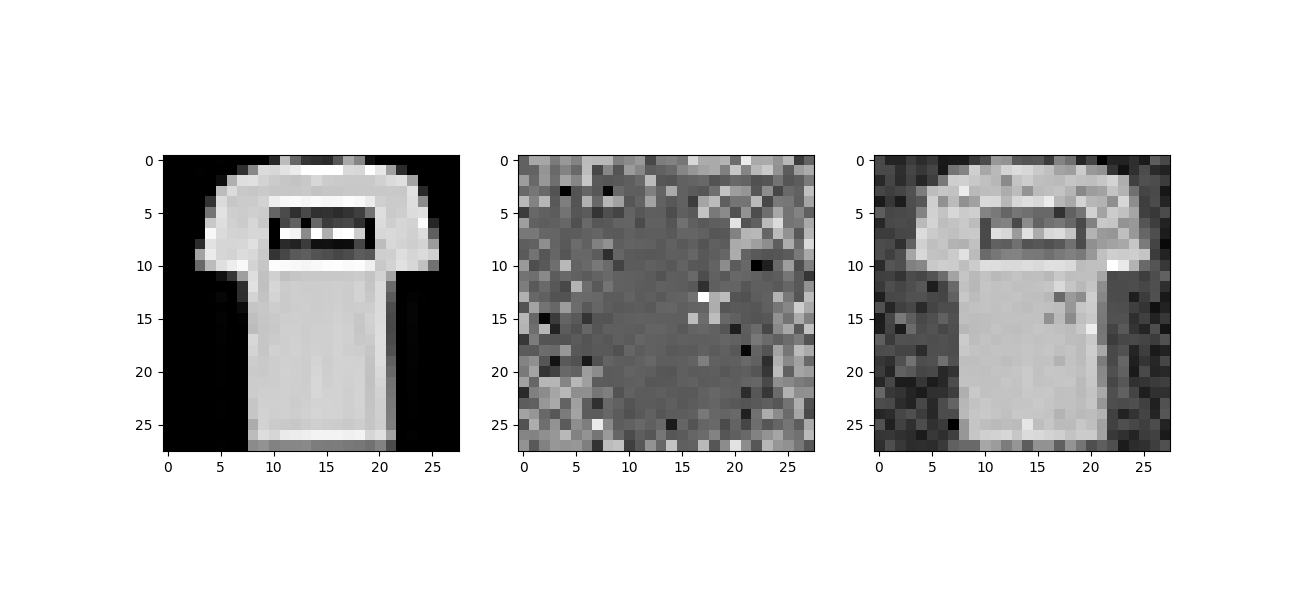

In [28]:
%matplotlib notebook

compare_fig, compare_ax = plt.subplots(1, 3, figsize=(13, 6))
compare_ax[0].imshow(images[0], cmap='gray')
compare_ax[1].imshow(final_pop.individuals[55], cmap='gray')
compare_ax[2].imshow(images[0] - final_pop.individuals[55], cmap='gray')

In [ ]:
model(np.reshape(final_pop.individuals[45] + images[4472], (-1, 28, 28, 1)))

In [ ]:
target_scores = model(np.reshape(final_pop.individuals[45] + images[:32], (-1, 28, 28, 1)))[:, target_class]

In [ ]:
target_scores[2]

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(8, 8, figsize=(10, 10))
fig.tight_layout()

In [ ]:
for i in range(64):
    ax[i // 8, i % 8].axis('off')
    ax[i // 8, i % 8].imshow(final_pop.individuals[i])
# plt.axisi

In [ ]:
fig.canvas